
**Integrantes:**
 - Mendoza Saenz de Buruaga Imanol
 - Enrique Villalon Pneda

Descargar el urban Consumer Price Index from the US. Bureau of Labor Statistics de https://research.stlouisfed.org/fred2/series/CPIAUCSL/downloaddata. Contiene valores mensuales del cambio porcentual del costo de alimentos, comida, ropa, habitación y combustibles en relación con una fecha inicial; cambios grandes en el Consumer Price Index indican inflación o deflación económica. Con ayuda de estos datos, compara el rendimiento de las
predicciones obtenidas por los modelos:
* Media móvil
* Exponencial
* Holt-Winters
* Regresión lineal

De preferencia utilizar las implementaciónes de las bibliotecas de Python

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

plt.rcParams['figure.figsize'] = (6,3)
plt.style.use('ggplot')

In [10]:

# Anuncios por mes
ads = pd.read_csv('/content/CPIAUCSL.csv')

#La fecha como indice
ads['DATE'] = pd.to_datetime(ads['DATE'])
ads.set_index('DATE', inplace=True)

ads.head()

,CPIAUCSL
DATE,
1947-01-01,21.48
1947-02-01,21.62
1947-03-01,22.00
1947-04-01,22.00
1947-05-01,21.95


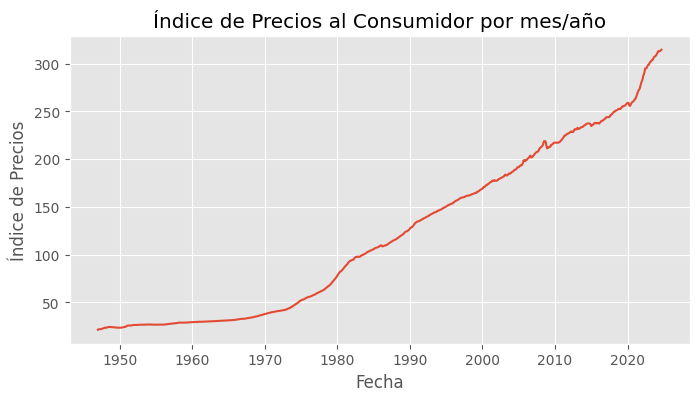

In [11]:
plt.figure(figsize=(8, 4))
plt.plot(ads['CPIAUCSL'])
plt.xlabel('Fecha')
plt.ylabel('Índice de Precios')
plt.title('Índice de Precios al Consumidor por mes/año')
plt.grid(True)
plt.show()

##Media movil

In [12]:
# media movil
def moving_average(series, n):
    return np.average(series[-n:])

moving_average(ads, 24)

306.93845833333336

In [13]:
from sklearn.metrics import mean_absolute_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import matplotlib.pyplot as plt
def plot_moving_average(series, window, plot_intervals = False, scale = 1.96, plot_anomalies = False):

    rolling_mean = series.rolling(window = window).mean()   # version de pandas para la media movil
    plt.figure(figsize=(12,5))
    plt.title('Media móvil \ntamaño de la ventana = {}'.format(window))
    plt.plot(rolling_mean, color='darkseagreen', label = 'Tendencia por media móvil')

    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        low_ = rolling_mean - (mae + scale * deviation)
        upp_ = rolling_mean + (mae + scale * deviation)
        plt.plot(upp_, 'blue', linestyle='--', label='Límites inferior/superior')
        plt.plot(low_, 'blue', linestyle='--' )
    #
    if plot_anomalies:
        anom = pd.DataFrame(index=series.index, columns=series.columns)
        anom[series<low_] = series[series<low_]
        anom[series>upp_] = series[series>upp_]
        plt.plot(anom, 'ro', markersize=7)

    plt.plot(series[window:], color='red', label='Valores reales')
    plt.legend(loc='best')
    plt.show()

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


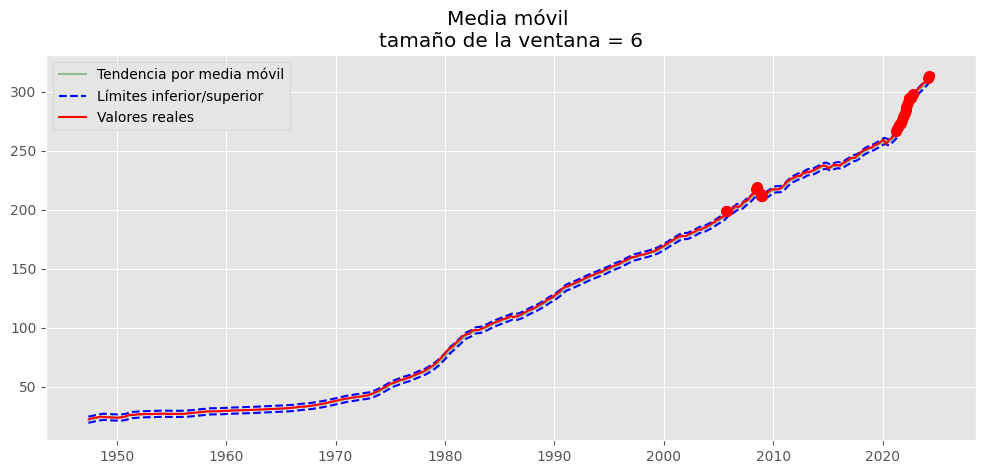

In [14]:
plot_moving_average(ads, 6, plot_intervals=True, plot_anomalies=True)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


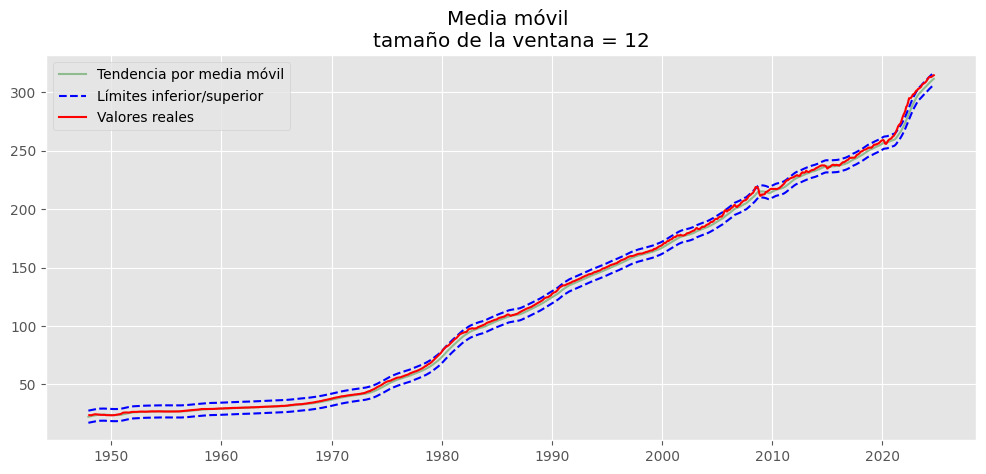

In [15]:
plot_moving_average(ads, 12, plot_intervals=True)

##suavizando exponencial

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_exponential_smoothing(series, alphas):

  sns.set_style('darkgrid')
  plt.figure(figsize=(12,5))

  # Loop through each alpha and plot the smoothed series
  for alpha in alphas:
    # Calculate exponential moving average using pandas' ewm function
    smoothed_series = series.ewm(alpha=alpha, adjust=False).mean()
    plt.plot(smoothed_series, label=f'alpha: {alpha}')

  # Plot the original series for comparison
  plt.plot(series, label='Serie original')
  plt.legend(loc='best')
  plt.title('Media exponencial suavizada')
  plt.grid(True)
  plt.show()

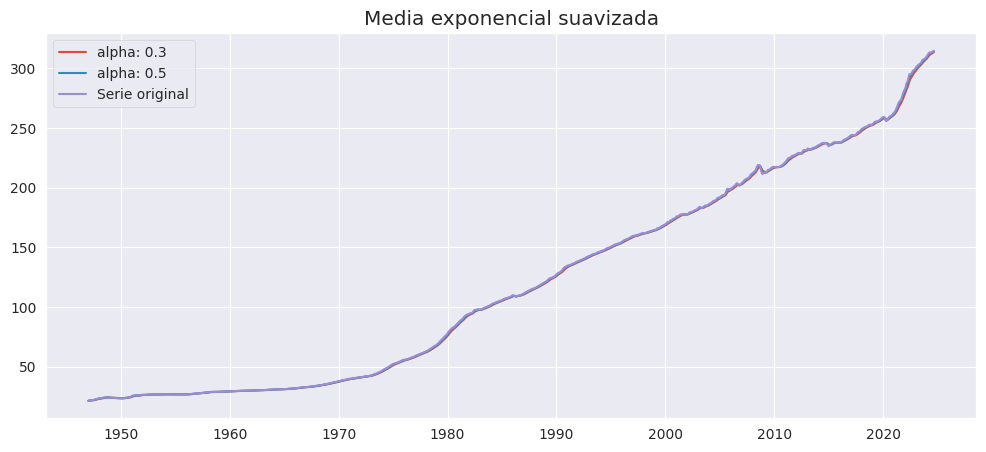

In [21]:
plot_exponential_smoothing(ads, [ 0.3, 0.5])

In [22]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def plot_hw_smoothing(series, n=20):
    hw = ExponentialSmoothing((series), seasonal_periods=12).fit()

    # prediccion
    train, test = series[:-n], series[len(series)-n:]
    hw_pred = hw.predict(start=test.index[0], end=test.index[-1])
    plt.figure(figsize=(15,5))
    plt.plot(train.index, train, label='Entrenamiento')
    plt.plot(test.index, test, label='Prueba')
    plt.plot(hw_pred.index, hw_pred, label='Holt-Winters')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


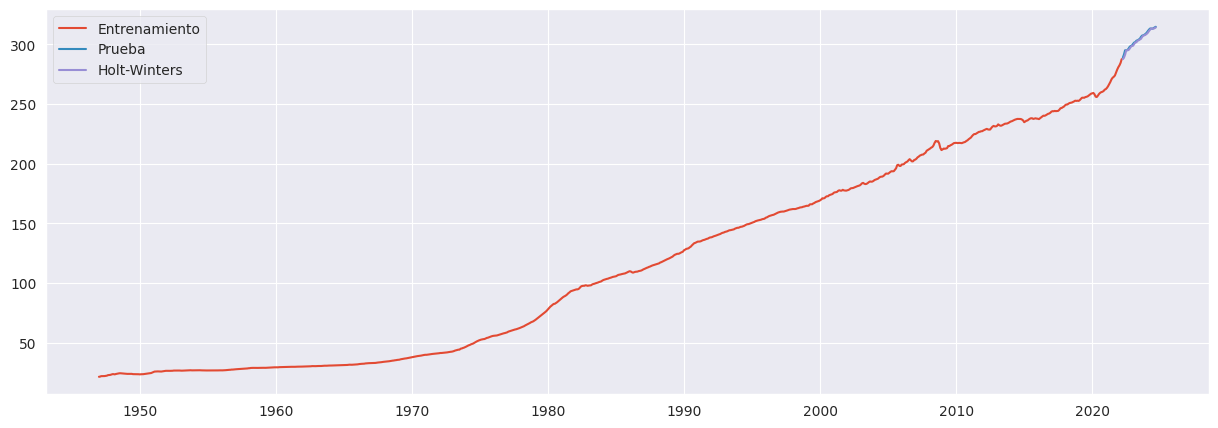

In [24]:
plot_hw_smoothing(ads, 30)

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
tscv=TimeSeriesSplit(n_splits=5)

In [32]:
def timeseries_train_test_split(X, y, test_size):

  test_index = int(len(X) * (1 - test_size))

  X_train = X[:test_index]
  y_train = y[:test_index]
  X_test = X[test_index:]
  y_test = y[test_index:]

  return X_train, X_test, y_train, y_test

In [33]:
X = ads.index.values.reshape(-1, 1)
y = ads['CPIAUCSL'].values

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)


In [34]:
lr=LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [40]:
!pip install pandas numpy scikit-learn matplotlib

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

def plot_lr_ts(model, X_train, X_test, y_train, y_test, scale=1.96, plot_intervals=False, plot_anomalies=False):
    # Convert X_test to numerical representation before prediction
    X_test_numeric = X_test.astype(int)  # or X_test.view(np.int64) if using numpy datetime

    pred = model.predict(X_test_numeric)  # Use the numeric version for prediction
    plt.figure(figsize=(15, 7))
    plt.plot(pred, 'g', label='Predicción', linewidth=2)

    # Directly plot y_test as it is already a NumPy array
    plt.plot(y_test, label='Real', linewidth=2)

    if plot_intervals:
        tscv = TimeSeriesSplit(n_splits=5)  # Assuming tscv is defined elsewhere
        cv = cross_val_score(model, X_train.astype(int), y_train, cv=tscv, scoring='neg_mean_absolute_error')
        mae = cv.mean() * (-1)
        dev = cv.std()
        low = pred - (mae + scale * dev)
        upp = pred + (mae + scale * dev)
        plt.plot(low, 'r--', label='límite inferior/superior', alpha=0.5)
        plt.plot(upp, 'r--', alpha=0.5)

    error = mean_absolute_percentage_error(pred, y_test)
    plt.title('Error absoluto promedio = {0:.3f}%'.format(error))
    plt.legend(loc='best')
    plt.tight_layout()
    plt.grid(True)
    plt.show()


def plot_coefs(model):
    coefs = pd.DataFrame(model.coef_, X_train.columns, columns=['coef']) # Assign column name explicitly
    coefs['abs'] = coefs['coef'].apply(np.abs) # Access column using bracket notation
    coefs = coefs.sort_values(by='abs', ascending=False).drop(['abs'], axis=1)
    plt.figure(figsize=(8, 3))
    coefs['coef'].plot(kind='bar') # Access column using bracket notation
    plt.grid(True, axis='y')
    plt.show()

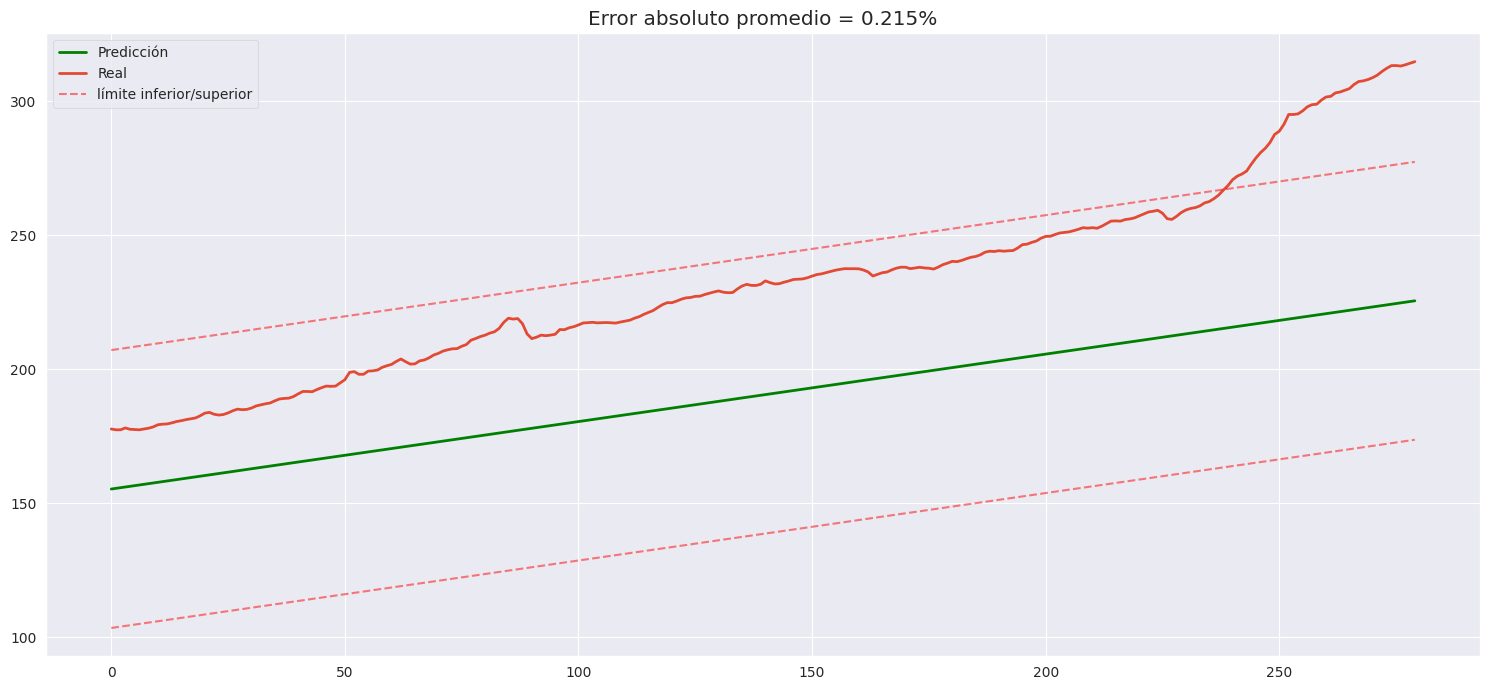

In [41]:
plot_lr_ts(lr, X_train, X_test, y_train, y_test, plot_intervals=True)